# <font color='navy'>**2. Sentiment Analysis**
Allison Aprile

Assignment 4

April 30, 2021

In [222]:
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from google.colab import drive
from nltk import word_tokenize, sent_tokenize, pad_sequence
import sys
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, Flatten, MaxPool1D, Dense, LSTM, Bidirectional, Concatenate
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from bs4 import BeautifulSoup
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='navy'>**(a) Preprocess the data**

In [365]:
'''
Processes review text files:
  - Use BeautifulSoup to extract text between <review_text> tags
  - Remove '\n' and other characters (punctuation)
  - Normalize (lowercasing all text)
  - Tokenize

Returns:
  - samples: list of cleaned reviews
  - tokens: list of tokenized reviews
'''
def process_text(file):
  # Open file
  with open(file, 'rb') as f:
    # Read as string (Because of encoding issue, result is a byte string)
    text = f.read()

    # Get all reviews using BeautifulSoup
    # Instantiate BeautifulSoup on file
    soup = BeautifulSoup(text)

    # Get all strings within <review_text> tags
    reviews = [review.string for review in soup.find_all('review_text')]

    # Replace any '\n' characters (for formatting) and normalize
    data = [d.replace('\n', ' ').lower() for d in reviews]

    # Tokenize sentences
    tokens = [word_tokenize(d) for d in data]

    # Remove any non-alphanumeric tokens (including punctuation) and stopwrods
    tokens = [[t for t in toks if t.isalpha() and len(t) > 1] for toks in tokens]

    # Join for individual training texts
    samples = [' '.join(lst) for lst in tokens]

    return samples, tokens

In [233]:
# Choose texts
review_texts = {'positive.review': 1, 'negative.review': 0}

In [234]:
# Define lists for each set of data (80% training, 10% validation, 10% testing)
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Iterate through each of the texts and add to data subsets
for r in review_texts.keys():
  # Get samples (paragraphs) and tokenized sentences
  samples, tokens = process_text('/content/drive/My Drive/a4-data/q2/' + r)

  # Allocate tokens to training, validation, and testing lists
  x_train, x_test, train_y, test_y = train_test_split(samples, [review_texts[r]]*len(samples), test_size=0.2, train_size=0.8)
  x_val, x_test, val_y, test_y = train_test_split(x_test, test_y, test_size=0.5, train_size=0.5)

  X_train += x_train
  y_train += train_y
  X_val += x_val
  y_val += val_y
  X_test += x_test
  y_test += test_y


In [300]:
# Create vocabulary from training dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulary = tokenizer.word_index

# Integer encode all datasets
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_val_encoded = tokenizer.texts_to_sequences(X_val)

# Pad all datasets to length 75
X_train_encoded = pad_sequences(X_train_encoded, maxlen=75, padding='post')
X_test_encoded = pad_sequences(X_test_encoded, maxlen=75, padding='post')
X_val_encoded = pad_sequences(X_val_encoded, maxlen=75, padding='post')

In [301]:
# Confirm shapes
print(len(X_train))
print(X_train_encoded.shape)
print(len(y_train))
print()

print(len(X_val))
print(X_val_encoded.shape)
print(len(y_val))
print()

print(len(X_test))
print(X_test_encoded.shape)
print(len(y_test)) 

1600
(1600, 75)
1600

200
(200, 75)
200

200
(200, 75)
200


In [237]:
# Load GLoVe for text embeddings
# Open GloVe values downloaded from https://nlp.stanford.edu/projects/glove/
fi = open('/content/drive/My Drive/a4-data/glove.6B.50d.txt', 'r')

# Initialize embedding dictionary
glove = {}

# Record each word as a key and its embedding vector as a value in glove dictionary
for li in fi:
  # Split into word and each embedding value
  line = li.split()

  # Take first element as word
  word = line[0]

  # Take remaining elements as embedding values
  value = np.array([float(val) for val in line[1:]])

  # Add word to dictionary
  glove[word] = value

# Close file
fi.close()

In [238]:
# Initialize word vectors using pre-trained Glove embeddings
def embed_text(glove_dict, vocabulary):
  # Get list of all GLoVe keys
  glove_keys = list(glove_dict.keys())

  # Initialize word embedding matrix with zeros
  word_embeddings = np.zeros((len(vocabulary) + 1, 50))

  # Update word embeddings by mapping each vocabulary word
  # to its corresponding GLoVe vector
  for key, value in vocabulary.items():
    # For names and uncommon words
    if key not in glove_keys:
      # Map to unk value
      word_vec = glove_dict['unk']
    
    # For common words (words covered by GLoVe)
    else:
      word_vec = glove_dict['key']

    # Update word_embeddings
    word_embeddings[value] = word_vec

  return word_embeddings

In [302]:
# Initialize word vectors using GLoVe
word_embeddings = embed_text(glove, vocabulary)

# Confirm
print(word_embeddings.shape)

(19034, 50)


# <font color='navy'>**(b) Build models (Implement forward pass)**

### **CNN**

In [337]:
# Define Sequential model as base 
cnn = Sequential()

# Initialize Embedding layer with GLoVe embeddings
cnn.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 75, trainable = True))

# Add Convolutional block - padding = 'same' zero pads input matrix
cnn.add(Conv1D(64, 3, activation='relu', input_shape=(50,), padding='same'))
cnn.add(MaxPool1D(2,2))

# Flatten
cnn.add(Flatten())

# Add MLP for output 
#cnn.add(Dense(10, activation='relu')) # Additional hidden layer
cnn.add(Dense(1, activation='sigmoid')) # Output layer

In [338]:
# Print summary
cnn.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 75, 50)            951700    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 75, 64)            9664      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 37, 64)            0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 2368)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 2369      
Total params: 963,733
Trainable params: 963,733
Non-trainable params: 0
_________________________________________________________________


### **LSTM 1 - Max Valued Hidden States as Context Vector**

In [339]:
# Define Sequential model as base 
lstm_1 = Sequential()

# Initialize Embedding layer with GLoVe embeddings
lstm_1.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 75, trainable = True))

# LSTM layer with Bidirectional wrapper - return_sequences = True to output all hidden states
lstm_1.add(Bidirectional(LSTM(16, activation='tanh', input_shape=(50,), return_sequences=True)))

# Take element-wise maximum of all hidden states
lstm_1.add(MaxPool1D())

# Flatten
lstm_1.add(Flatten())

# Dense prediction layer
lstm_1.add(Dense(1, activation='sigmoid'))

In [340]:
# Print summary
lstm_1.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     (None, 75, 50)            951700    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 75, 32)            8576      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 1185      
Total params: 961,461
Trainable params: 961,461
Non-trainable params: 0
_________________________________________________________________


### **LSTM 2 - Last Hidden State as Context Vector**

In [341]:
# Define Sequential model as base 
lstm_2 = Sequential()

# Initialize Embedding layer with GLoVe embeddings
lstm_2.add(Embedding(len(vocabulary) + 1, 50, weights = [word_embeddings],
                    input_length = 75, trainable = True))

# LSTM layer with Bidirectional wrapper - return_sequences = False to output only last hidden state
lstm_2.add(Bidirectional(LSTM(16, activation='tanh', input_shape=(50,), return_sequences=False)))

# Dense prediction layer
lstm_2.add(Dense(1, activation='sigmoid'))

In [342]:
# Print summary
lstm_2.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 75, 50)            951700    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 32)                8576      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 33        
Total params: 960,309
Trainable params: 960,309
Non-trainable params: 0
_________________________________________________________________


# <font color='navy'>**(c) Backpropagation**

In [343]:
# Compile all models with Adam optimizer and 1e-3 learning rate
cnn.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
lstm_1.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
lstm_2.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [344]:
# Calculate the initial training categorical cross entropy losses of the models
print('CNN Initial Loss: ', cnn.evaluate(X_train_encoded, np.array(y_train))[0])
print()

print('LSTM (All Hidden Layers) Initial Loss: ', lstm_1.evaluate(X_train_encoded, np.array(y_train))[0])
print()

print('LSTM (Last Hidden Layer) Initial Loss: ', lstm_2.evaluate(X_train_encoded, np.array(y_train))[0])

50/50 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.6241
CNN Initial Loss:  0.7007375955581665

50/50 [==============================] - 2s 11ms/step - loss: 0.7365 - accuracy: 0.1689
LSTM (All Hidden Layers) Initial Loss:  0.694917619228363

50/50 [==============================] - 3s 10ms/step - loss: 0.6122 - accuracy: 0.8342
LSTM (Last Hidden Layer) Initial Loss:  0.7098873257637024



# <font color='navy'>**(d) Train Models**

### **CNN**

In [345]:
# Fit model on training data for 5 epochs
cnn_history = cnn.fit(X_train_encoded, np.array(y_train), epochs=5, batch_size=32,
                      validation_data=(X_val_encoded, np.array(y_val)))

Epoch 1/5
50/50 [==============================] - 2s 24ms/step - loss: 0.7087 - accuracy: 0.5006 - val_loss: 0.6936 - val_accuracy: 0.5050
Epoch 2/5
50/50 [==============================] - 1s 20ms/step - loss: 0.6761 - accuracy: 0.5813 - val_loss: 0.6917 - val_accuracy: 0.5250
Epoch 3/5
50/50 [==============================] - 1s 20ms/step - loss: 0.6504 - accuracy: 0.6506 - val_loss: 0.6967 - val_accuracy: 0.5100
Epoch 4/5
50/50 [==============================] - 1s 20ms/step - loss: 0.6085 - accuracy: 0.7819 - val_loss: 0.6929 - val_accuracy: 0.4950
Epoch 5/5
50/50 [==============================] - 1s 20ms/step - loss: 0.5344 - accuracy: 0.8950 - val_loss: 0.6982 - val_accuracy: 0.4950


For the CNN, I tried 16, 32, 64, and 128 filters, as well as 1x1 and 3x3 for the kernel size. I also tried no Dense layer and Dense layers with 10 and 100 neurons for the top layer MLP. Surprisingly to me, the lower numbers of filters performed better, observing the best validation loss/accuracy at 64. However, for all combinations, the performance margin was very small. Because CNN is SOTA (moreso for computer vision, but upcoming for NLP tasks), I was disappointed in this performance. I tried increasing/decreasing the input sizes of the word vectors (25, 50, 75, 100) and unfreezing/freezing the Embedding layer, but all efforts did not have an impact on performance. 

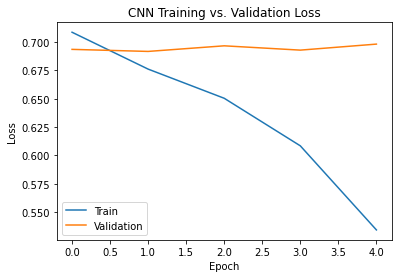

In [346]:
# Plot training and validation loss curves 
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

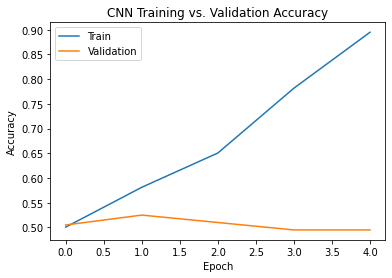

In [347]:
# Plot training and validation accuracy curves
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [348]:
# Get testing predictions
cnn_pred = list(cnn.predict(X_test_encoded))

# Convert to 1 and 0
cnn_pred = [1 if x > 0.5 else 0 for x in cnn_pred]

In [349]:
# Check if testing dataset is balanced
Counter(y_test)

Counter({0: 100, 1: 100})

In [350]:
# Because testing set is balanced, report only accuracy
print(accuracy_score(y_test, cnn_pred))

0.53


### **LSTM 1 - Max Valued Hidden States as Context Vector**

In [351]:
# Fit model on training data for 10 epochs
lstm_1_history = lstm_1.fit(X_train_encoded, np.array(y_train), epochs=10, batch_size=32,
                      validation_data=(X_val_encoded, np.array(y_val)))

Epoch 1/10
50/50 [==============================] - 7s 69ms/step - loss: 0.6965 - accuracy: 0.4931 - val_loss: 0.6930 - val_accuracy: 0.5150
Epoch 2/10
50/50 [==============================] - 2s 47ms/step - loss: 0.6798 - accuracy: 0.5369 - val_loss: 0.6865 - val_accuracy: 0.5450
Epoch 3/10
50/50 [==============================] - 2s 48ms/step - loss: 0.6212 - accuracy: 0.7450 - val_loss: 0.6271 - val_accuracy: 0.7200
Epoch 4/10
50/50 [==============================] - 2s 49ms/step - loss: 0.3763 - accuracy: 0.8594 - val_loss: 0.5976 - val_accuracy: 0.6800
Epoch 5/10
50/50 [==============================] - 2s 48ms/step - loss: 0.1224 - accuracy: 0.9688 - val_loss: 0.7451 - val_accuracy: 0.6700
Epoch 6/10
50/50 [==============================] - 2s 47ms/step - loss: 0.0443 - accuracy: 0.9925 - val_loss: 0.9013 - val_accuracy: 0.6800
Epoch 7/10
50/50 [==============================] - 2s 48ms/step - loss: 0.0203 - accuracy: 0.9962 - val_loss: 1.1304 - val_accuracy: 0.6950
Epoch 8/10
50

For this LSTM, I had a similar experience as with the CNN - when trying the varying hidden state sizes (16, 32, 64, 128), I noticed that the lower size led to better performance. I also observed that taking the element-wise maximum (verus average) of all the states after the Bidirectional LSTM layer yielded better performance. Ultimately, this is not ideal performance (only slightly better than random guess), but it still learned more than the CNN.

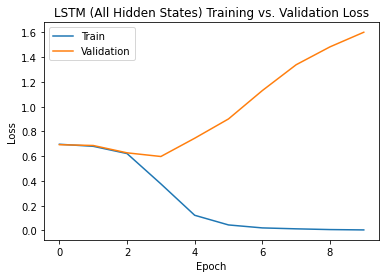

In [352]:
# Plot training and validation loss curves 
plt.plot(lstm_1_history.history['loss'])
plt.plot(lstm_1_history.history['val_loss'])
plt.title('LSTM (All Hidden States) Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

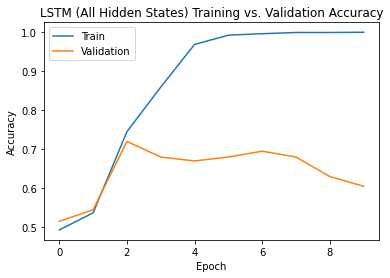

In [353]:
# Plot training and validation accuracy curves 
plt.plot(lstm_1_history.history['accuracy'])
plt.plot(lstm_1_history.history['val_accuracy'])
plt.title('LSTM (All Hidden States) Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [354]:
# Get testing predictions
lstm_1_pred = list(lstm_1.predict(X_test_encoded))

# Convert to 1 and 0
lstm_1_pred = [1 if x > 0.5 else 0 for x in lstm_1_pred]

In [355]:
# Because testing set is balanced, report only accuracy
print(accuracy_score(y_test, lstm_1_pred))

0.63


### **LSTM 2 - Last Hidden State as Context Vector**

In [356]:
# Fit model on training data for 10 epochs
lstm_2_history = lstm_2.fit(X_train_encoded, np.array(y_train), epochs=10, batch_size=32,
                      validation_data=(X_val_encoded, np.array(y_val)))

Epoch 1/10
50/50 [==============================] - 6s 65ms/step - loss: 0.6967 - accuracy: 0.4938 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 2s 46ms/step - loss: 0.6881 - accuracy: 0.5381 - val_loss: 0.6938 - val_accuracy: 0.5050
Epoch 3/10
50/50 [==============================] - 2s 49ms/step - loss: 0.6859 - accuracy: 0.5306 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 2s 47ms/step - loss: 0.6656 - accuracy: 0.6156 - val_loss: 0.6869 - val_accuracy: 0.5450
Epoch 5/10
50/50 [==============================] - 2s 47ms/step - loss: 0.5548 - accuracy: 0.7856 - val_loss: 0.5958 - val_accuracy: 0.7100
Epoch 6/10
50/50 [==============================] - 2s 48ms/step - loss: 0.3319 - accuracy: 0.8950 - val_loss: 0.5167 - val_accuracy: 0.7600
Epoch 7/10
50/50 [==============================] - 2s 48ms/step - loss: 0.1589 - accuracy: 0.9619 - val_loss: 0.5647 - val_accuracy: 0.7850
Epoch 8/10
50

For this LSTM, I followed the same hyperparameter tuning as with the CNN and prior LSTM. I once again found that unfreezing the Embedding layer, using a hidden state size of 16 yieled the best validation performance. Surprisingly, it learned more than the LSTM that used all of the hidden states. 

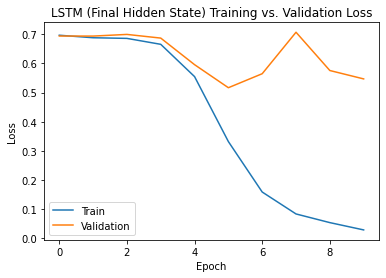

In [357]:
# Plot training and validation loss curves 
plt.plot(lstm_2_history.history['loss'])
plt.plot(lstm_2_history.history['val_loss'])
plt.title('LSTM (Final Hidden State) Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

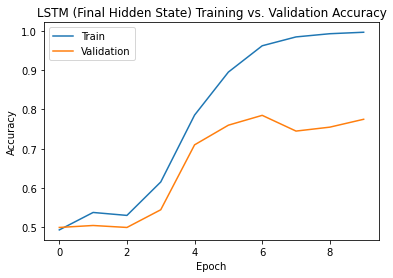

In [358]:
# Plot training and validation accuracy curves 
plt.plot(lstm_2_history.history['accuracy'])
plt.plot(lstm_2_history.history['val_accuracy'])
plt.title('LSTM (Final Hidden State) Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [359]:
# Get testing predictions
lstm_2_pred = list(lstm_2.predict(X_test_encoded))

# Convert to 1 and 0
lstm_2_pred = [1 if x > 0.5 else 0 for x in lstm_2_pred]

In [360]:
# Because testing set is balanced, report only accuracy
print(accuracy_score(y_test, lstm_2_pred))

0.775



# <font color='navy'>**(e) Compare Models**

In [362]:
# Store data
models = ['CNN', 'LSTM (All Hidden States)', 'LSTM (Final Hidden State)']
accuracies = [0.53, 0.63, 0.775]

In [363]:
# Zip data into dataframe
performance = pd.DataFrame(list(zip(models, accuracies)), columns=['Model', 'Accuracy'])

In [364]:
# Print table
performance

,Model,Accuracy
0,CNN,0.530
1,LSTM (All Hidden States),0.630
2,LSTM (Final Hidden State),0.775
